# 통계적 검정 실습파일

# 순열검정 (Permutation_test)

재표본추출을 직접 해보고싶어서 만든 페이지입니다.

가진 데이터를 활용하여(이 통계 교재 실습을 위해 만들어진 데이터가 아닌) 귀무가설을 기각하는 경우를 보고싶었습니다.

이전에 AI 공부를 할 때 함께했던 멜버른 집값 데이터를 데려옵니다.

## Data, library import

In [1]:
# 라이브러리 불러오기

%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from scipy import stats
from sklearn.utils import resample
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import seaborn as sns
import matplotlib.pylab as plt

import warnings

In [2]:
mel_price = pd.read_csv('/Users/Angela/Desktop/Personal/AI_data/melb_data.csv')

## data info

In [3]:
mel_price.nunique()

Suburb             314
Address          13378
Rooms                9
Type                 3
Price             2204
Method               5
SellerG            268
Date                58
Distance           202
Postcode           198
Bedroom2            12
Bathroom             9
Car                 11
Landsize          1448
BuildingArea       602
YearBuilt          144
CouncilArea         33
Lattitude         6503
Longtitude        7063
Regionname           8
Propertycount      311
dtype: int64

In [4]:
mel_price.sample(10)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
2711,Footscray,4/2 Saltriver Pl,3,u,665000.0,S,Greg,18/06/2016,6.4,3011.0,...,2.0,1.0,0.0,NaN,NaN,Maribyrnong,-37.80160,144.90820,Western Metropolitan,7570.0
1967,Coburg,3 Phillips St,3,h,1030000.0,S,Considine,17/09/2016,7.8,3058.0,...,1.0,1.0,404.0,NaN,NaN,Moreland,-37.75040,144.95370,Northern Metropolitan,11204.0
10624,Coburg,251 Bell St,2,h,760000.0,S,Nelson,8/07/2017,6.7,3058.0,...,1.0,2.0,378.0,105.0,1920.0,Moreland,-37.74011,144.95267,Northern Metropolitan,11204.0
11285,Blackburn,17 Hirst St,3,h,1070000.0,S,Jellis,15/07/2017,13.4,3130.0,...,1.0,2.0,448.0,96.0,1950.0,Whitehorse,-37.82956,145.13868,Eastern Metropolitan,5713.0
6786,Brunswick East,3/37 Brunswick Rd,2,u,665000.0,S,Collins,16/07/2016,4.5,3057.0,...,1.0,1.0,0.0,96.0,1940.0,Moreland,-37.77860,144.97530,Northern Metropolitan,5533.0
8565,Albion,2/62 Selwyn St,3,u,600000.0,SA,Douglas,20/05/2017,13.9,3020.0,...,1.0,1.0,181.0,129.0,2000.0,Brimbank,-37.78150,144.81280,Western Metropolitan,2185.0
4636,Pascoe Vale,1/5 Farringdon St,3,t,790000.0,S,Brad,12/11/2016,9.9,3044.0,...,3.0,1.0,291.0,175.0,2009.0,Moreland,-37.72710,144.92610,Northern Metropolitan,7485.0
5703,South Yarra,366 Toorak Rd,3,h,1700000.0,S,Morrison,27/11/2016,3.3,3141.0,...,1.0,1.0,178.0,172.0,1894.0,Stonnington,-37.84040,145.00220,Southern Metropolitan,14887.0
11984,Elwood,1/121 Brighton Rd,2,u,720000.0,S,Chisholm,29/07/2017,7.2,3184.0,...,1.0,2.0,797.0,90.0,1920.0,Port Phillip,-37.87449,144.99059,Southern Metropolitan,8989.0
10382,Maidstone,1 Gilda St,3,h,793000.0,S,hockingstuart,27/05/2017,6.4,3012.0,...,1.0,2.0,417.0,NaN,NaN,Maribyrnong,-37.78867,144.87397,Western Metropolitan,3873.0


In [5]:
# 필요한 데이터만 사용하기로 합니다.

df = mel_price[['Regionname', 'Type', 'Rooms', 'Bathroom', 'Landsize', 'Price']]

In [6]:
df.head()

,Regionname,Type,Rooms,Bathroom,Landsize,Price
0,Northern Metropolitan,h,2,1.0,202.0,1480000.0
1,Northern Metropolitan,h,2,1.0,156.0,1035000.0
2,Northern Metropolitan,h,3,2.0,134.0,1465000.0
3,Northern Metropolitan,h,3,2.0,94.0,850000.0
4,Northern Metropolitan,h,4,1.0,120.0,1600000.0


In [7]:
df.nunique()

Regionname       8
Type             3
Rooms            9
Bathroom         9
Landsize      1448
Price         2204
dtype: int64

# 지역에 따른 집값 차이가 유의미한가?

In [8]:
df['Regionname'].unique()

array(['Northern Metropolitan', 'Western Metropolitan',
       'Southern Metropolitan', 'Eastern Metropolitan',
       'South-Eastern Metropolitan', 'Eastern Victoria',
       'Northern Victoria', 'Western Victoria'], dtype=object)

In [9]:
# Metropolitan 과 Victoria 로 나누어본다.

df[['Direction', 'Region']] = df['Regionname'].str.split(' ', n = 2, expand=True)
df.head()

/var/folders/qw/j72d9nwn5dq0vxtqtw2bbtnh0000gp/T/ipykernel_18735/4227768033.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Direction', 'Region']] = df['Regionname'].str.split(' ', n = 2, expand=True)
/var/folders/qw/j72d9nwn5dq0vxtqtw2bbtnh0000gp/T/ipykernel_18735/4227768033.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['Direction', 'Region']] = df['Regionname'].str.split(' ', n = 2, expand=True)


,Regionname,Type,Rooms,Bathroom,Landsize,Price,Direction,Region
0,Northern Metropolitan,h,2,1.0,202.0,1480000.0,Northern,Metropolitan
1,Northern Metropolitan,h,2,1.0,156.0,1035000.0,Northern,Metropolitan
2,Northern Metropolitan,h,3,2.0,134.0,1465000.0,Northern,Metropolitan
3,Northern Metropolitan,h,3,2.0,94.0,850000.0,Northern,Metropolitan
4,Northern Metropolitan,h,4,1.0,120.0,1600000.0,Northern,Metropolitan


In [10]:
df['Region'].value_counts()

Metropolitan    13454
Victoria          126
Name: Region, dtype: int64

In [11]:
df[df['Region'] == 'Metropolitan']['Price'].mean()

1080242.4607551657

In [12]:
df[df['Region'] == 'Victoria']['Price'].mean()

588950.253968254

차이가 꽤 존재한다. 거의 두 배 차이나는데 데이터 분석가로서, 다른 요인들을 먼저 분석해보려 한다.

In [13]:
df['Type'].unique()

array(['h', 'u', 't'], dtype=object)

In [14]:
df['Type'].value_counts()

h    9449
u    3017
t    1114
Name: Type, dtype: int64

In [15]:
df[df['Type'] == 'h']['Price'].mean()

1242664.761138745

In [16]:
df[df['Type'] == 'u']['Price'].mean()

605127.4845873384

In [17]:
df[df['Type'] == 't']['Price'].mean()

933735.0538599641

Metropolitan  집값이 훨씬 비싸고, 하우스 타입이 h가 비싼 편인 것으로 나타났다. 

Metropolitan 에 h 유형이 많은가?

In [18]:
df_h = df[df['Type'] =='h'][['Region', 'Price']]

In [19]:
df_h['Region'].value_counts()

Metropolitan    9326
Victoria         123
Name: Region, dtype: int64

재미있는건 h타입에 Victoria 지역의 집이 많다.  

126개 중 123개가 있다고? 그렇다면 각각의 평균 가격은?

In [20]:
# 소수점 아래 2까지만 보이도록 한다

pd.options.display.float_format = '{:.2f}'.format
pd.crosstab(index = df['Region'], columns = df['Type'], values = df['Price'], aggfunc = 'mean' )

Type,h,t,u
Region,,,
Metropolitan,1251245.51,933735.05,605270.61
Victoria,592062.86,NaN,461333.33


빅토리아에는 t타입이 아예 없는 것으로 나타났다.

이렇게만 보면 가격차가 나는 것처럼 보인다. 

지역 지도 한번 안보고 바로 분석을 시작한다니 좀 억지이긴 하지만, 지금 해보고 싶은건 순열검정이기 때문에, h타입만 가지고 할 것이며,

어느 정도 공정한 분석을 위해 집 크기를 고려하여 Victoria 에서의 가장 큰집 이상을 벗어나는 집은 Metropolitan에서 제거하도록 한다.

<AxesSubplot:xlabel='Region', ylabel='Landsize'>

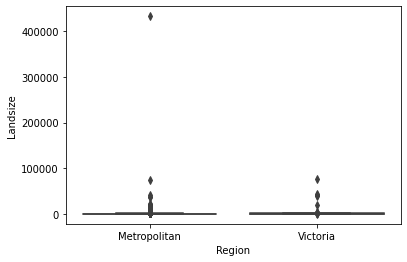

In [21]:
# 면적 분포

sns.boxplot(data = df, x = 'Region', y = 'Landsize')

이런이런 심각한 아기고양이가 있었네 지웁니다.

In [22]:
df[df['Region'] == 'Metropolitan'].sort_values(by = 'Landsize', ascending = False).head()

,Regionname,Type,Rooms,Bathroom,Landsize,Price,Direction,Region
11020,Northern Metropolitan,h,3,3.00,433014.00,2700000.00,Northern,Metropolitan
687,Southern Metropolitan,h,3,1.00,75100.00,2000000.00,Southern,Metropolitan
5194,Northern Metropolitan,h,3,1.00,41400.00,572000.00,Northern,Metropolitan
9223,Western Metropolitan,u,2,2.00,37000.00,585000.00,Western,Metropolitan
3942,Western Metropolitan,u,2,2.00,37000.00,495000.00,Western,Metropolitan


숫자로도 자릿수가 다를 만큼 확연하게 큰 저 값은 지우도록 합니다.

In [23]:
df = df.drop(index = 11020, axis=0)

<AxesSubplot:xlabel='Region', ylabel='Landsize'>

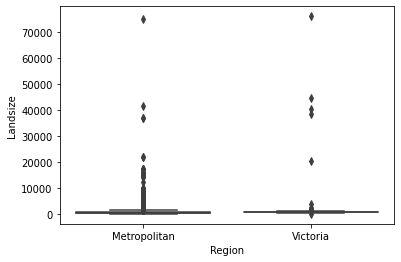

In [30]:
# 면적 분포 다시 확인

sns.boxplot(data = df, x = 'Region', y = 'Landsize')

다시 분포가 달라지긴 했지만, 보려는것은 가격입니다.

마찬가지로 가격을 볼 것이기 때문에 가격도 한 번 더 거르기로 합니다.

<AxesSubplot:xlabel='Region', ylabel='Price'>

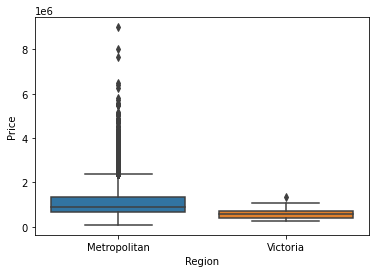

In [24]:
# 가격 분포

sns.boxplot(data = df, x = 'Region', y = 'Price')

<AxesSubplot:xlabel='Region', ylabel='Price'>

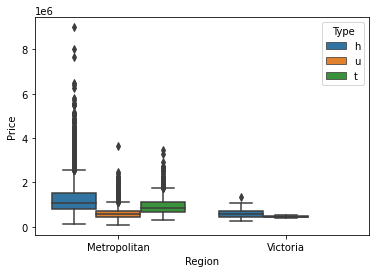

In [27]:
sns.boxplot(data = df, x = 'Region', y = 'Price', hue = 'Type')

메트로폴리탄 내에서도 차이가 많이 나는 값들이 있습니다. 지우고 나면 그래도 어느정도 빅토리아와 차이가 덜 할 것으로 보입니다. (빅토리아의 최소값은 메트로폴리탄보다 높음) 이들을 지우도록 하려고 합니다.

h타입만 분석을 진행할 것이므로 이들만 데려옵니다.

In [28]:
df_h = df[df['Type'] == 'h']

In [31]:
Met_price = df_h[df_h['Region'] == 'Metropolitan']['Price']

In [33]:
# 3/4 지점의 값 + 1.5 * 사분위수 범위

Metro_price_anormaly = Met_price.quantile(0.75) + (Met_price.quantile(0.75) - Met_price.quantile(0.25)) *1.5
Metro_price_anormaly

2555000.0

2555000 을 기준으로 나머지 메트로폴리탄 값들을 지웁니다.

In [35]:
df_h.drop(df_h.loc[df['Price'] > Metro_price_anormaly ].index, inplace=True)

/var/folders/qw/j72d9nwn5dq0vxtqtw2bbtnh0000gp/T/ipykernel_18735/3388185592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h.drop(df_h.loc[df['Price'] > Metro_price_anormaly ].index, inplace=True)


In [37]:
df_h['Region'].value_counts()

Metropolitan    8893
Victoria         123
Name: Region, dtype: int64

In [38]:
warnings.filterwarnings(action='ignore')

```
Metropolitan    9326
Victoria         123
```
에서
```
Metropolitan    8893
Victoria         123
```
로 일부 줄어들었다.

랜덤하게 Metropolitan에서 Victoria의 열 배 만 뽑아보도록 해보겠다. 갑자기 말투 무엇.

In [41]:
sample_df_M = df_h[df_h['Region'] == 'Metropolitan'].sample(1230)
sample_df_M.head()

,Regionname,Type,Rooms,Bathroom,Landsize,Price,Direction,Region
1090,Southern Metropolitan,h,2,1.00,318.00,1102000.00,Southern,Metropolitan
9203,Western Metropolitan,h,3,1.00,647.00,670000.00,Western,Metropolitan
7238,Western Metropolitan,h,3,1.00,347.00,967000.00,Western,Metropolitan
727,Southern Metropolitan,h,4,2.00,902.00,1815000.00,Southern,Metropolitan
4999,Northern Metropolitan,h,2,2.00,415.00,860000.00,Northern,Metropolitan


In [42]:
sample_df_V = df_h[df_h['Region'] == 'Victoria']
sample_df_V.head()

,Regionname,Type,Rooms,Bathroom,Landsize,Price,Direction,Region
8741,Eastern Victoria,h,4,2.00,687.00,627500.00,Eastern,Victoria
8789,Northern Victoria,h,2,1.00,610.00,621000.00,Northern,Victoria
8794,Northern Victoria,h,3,2.00,400.00,530500.00,Northern,Victoria
8815,Eastern Victoria,h,3,2.00,691.00,611000.00,Eastern,Victoria
8817,Northern Victoria,h,4,2.00,978.00,521000.00,Northern,Victoria


In [44]:
sample_df = pd.concat([sample_df_M, sample_df_V], axis = 0)
sample_df.head()

,Regionname,Type,Rooms,Bathroom,Landsize,Price,Direction,Region
1090,Southern Metropolitan,h,2,1.00,318.00,1102000.00,Southern,Metropolitan
9203,Western Metropolitan,h,3,1.00,647.00,670000.00,Western,Metropolitan
7238,Western Metropolitan,h,3,1.00,347.00,967000.00,Western,Metropolitan
727,Southern Metropolitan,h,4,2.00,902.00,1815000.00,Southern,Metropolitan
4999,Northern Metropolitan,h,2,2.00,415.00,860000.00,Northern,Metropolitan


이제 sample_df를 가지고 함수를 이용하여 관찰된 차이를 구해보고자 한다.



In [45]:
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

In [46]:
# 두 지역 개수 구하기

nA = sample_df[sample_df['Region'] == 'Metropolitan'].shape[0]
nB = sample_df[sample_df['Region'] == 'Victoria'].shape[0]

In [50]:
# 실행 전 index를 활용하는 함수에 맞춰서 리인덱싱 해주기

sample_df.reset_index(drop = True, inplace = True)
sample_df.head()

,Regionname,Type,Rooms,Bathroom,Landsize,Price,Direction,Region
0,Southern Metropolitan,h,2,1.00,318.00,1102000.00,Southern,Metropolitan
1,Western Metropolitan,h,3,1.00,647.00,670000.00,Western,Metropolitan
2,Western Metropolitan,h,3,1.00,347.00,967000.00,Western,Metropolitan
3,Southern Metropolitan,h,4,2.00,902.00,1815000.00,Southern,Metropolitan
4,Northern Metropolitan,h,2,2.00,415.00,860000.00,Northern,Metropolitan


In [53]:
meanPrice_M = sample_df[sample_df['Region'] == 'Metropolitan'].Price.mean()
meanPrice_V = sample_df[sample_df['Region'] == 'Victoria'].Price.mean()

In [52]:
# 위에서 정의한 함수로 평균의 차이 구하기
# 너무 오래 걸릴 수 있음을 방지하여 R = 500 번만 실험해 보기로 한다.
# 시간을 함께 계산하기로 한다.

import time
start = time.time()  # 시작 시간 저장
 
perm_diffs = [perm_fun(sample_df['Price'], nA, nB) for _ in range(500)]


print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 25.10065484046936


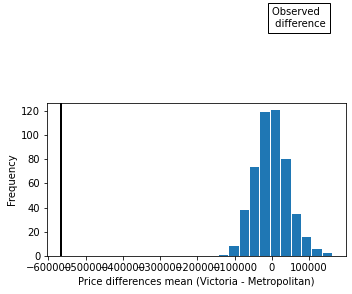

In [56]:
# 위 결과를 시각화한다.

fig, ax = plt.subplots(figsize = (5,5))
ax.hist(perm_diffs, bins =11, rwidth = 0.9) # 줄 너비 0.9
ax.axvline(x = meanPrice_V - meanPrice_M, color = 'black', lw = 2) # 원래 처음 결과(평균에서 평균을 뺀것) 선을 그어줌
# ax.text(50, 190, 'Observed \n difference', bbox = {'facecolor': 'white'}) # 선 설명 텍스트
ax.set_xlabel('Price differences mean (Victoria - Metropolitan)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [57]:
np.mean(np.array(perm_diffs) > meanPrice_V - meanPrice_M)

1.0

통계적으로 유의하지 않다는 결론입니다 ^^... 

이번에는 R=1000으로 높여본다.

In [58]:
# 위에서 정의한 함수로 평균의 차이 구하기
# 너무 오래 걸릴 수 있음을 방지하여 R = 500 번만 실험해 보기로 한다.
# 시간을 함께 계산하기로 한다.

import time
start = time.time()  # 시작 시간 저장
 
perm_diffs = [perm_fun(sample_df['Price'], nA, nB) for _ in range(1000)]


print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 53.216230154037476


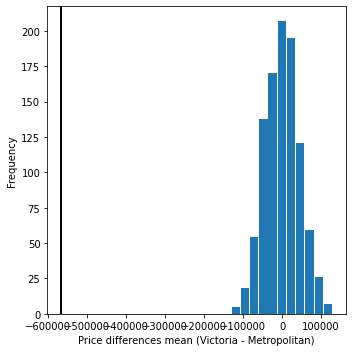

In [59]:
# 위 결과를 시각화한다.

fig, ax = plt.subplots(figsize = (5,5))
ax.hist(perm_diffs, bins =11, rwidth = 0.9) # 줄 너비 0.9
ax.axvline(x = meanPrice_V - meanPrice_M, color = 'black', lw = 2) # 원래 처음 결과(평균에서 평균을 뺀것) 선을 그어줌
# ax.text(50, 190, 'Observed \n difference', bbox = {'facecolor': 'white'}) # 선 설명 텍스트
ax.set_xlabel('Price differences mean (Victoria - Metropolitan)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [60]:
np.mean(np.array(perm_diffs) > meanPrice_V - meanPrice_M)

1.0

결론은 귀무가설을 기각하지 못한 것으로 나타났습니다. 심각하네요. 이런 아무 쓰잘데기 없는 분석을 하다니 조금 슬프니까 나중에 멜버른 집값은 다시 할것입니다.